In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree

In [2]:
# Reading in data and assigning it to variables even though Greg seems to think it's a waste of time.

# Read in data
hdulist = fits.open('http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr3/external/survey-dr3-specObj-dr13.fits') # survey
hdulist2 = fits.open('https://data.sdss.org/sas/dr13/sdss/spectro/redux/specObj-dr13.fits')
tbdata = hdulist[1].data
tbdata2 = hdulist2[1].data

# Put data in arrays

# Object ID from survey file; value -1 for non-matches
objid = []
objid = tbdata.field('OBJID') 

# Only galaxies included
gal_type = []
gal_type = tbdata.field('TYPE') 

# RA
ra = []
ra = tbdata.field('RA')

# Dec
dec = []
dec = tbdata.field('DEC')

no_LOWZ_cut = (((gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5))

# Number of observations of source from legacy file
# Not cut for LOWZ
obs = []
obsmatch = []
obs = tbdata.field('DECAM_NOBS') 
obsmatch = obs[np.where(no_LOWZ_cut)] 

# Put number of observations per filter into arrays that match the filter
uobs = []
gobs = []
robs = []
iobs = []
zobs = []
yobs = []

b = np.array(obsmatch)
uobs = b[:,0]
gobs = b[:,1]
robs = b[:,2]
iobs = b[:,3]
zobs = b[:,4]
yobs = b[:,5]

# Put flux data in an array from legacy file
# Flux has ugrizY, so needs to be divided into 6 arrays
flux =[]
fluxmatch = []

# Flux from DECAM
# Not cut for LOWZ
flux = tbdata.field('DECAM_FLUX')
fluxmatch = flux[np.where(no_LOWZ_cut)]

# Divide flux arrays into 6 arrays
uflux = []
gflux = []
rflux = []
iflux = []
zflux = []
yflux = []

a = np.array(fluxmatch)
uflux = a[:,0]
gflux = a[:,1]
rflux = a[:,2]
iflux = a[:,3]
zflux = a[:,4]
yflux = a[:,5]

# Class of object
gal_class = []
gal_class = tbdata2.field('CLASS')

# What survey the data is from
survey = []
survey = tbdata2.field('SURVEY')

# SPECPRIMARY; set to 1 for primary observation of object, 0 otherwise
spec = []
spec = tbdata2.field('SPECPRIMARY')

# Bitmask of spectroscopic warning values; need set to 0
zwarn_noqso = []
zwarn_noqso = tbdata2.field('ZWARNING_NOQSO')

# Spectroscopic classification for certain redshift?
class_noqso = []
class_noqso = tbdata2.field('CLASS_NOQSO')

# Redshift of galaxies according to sdss
redshift = []
redshift = tbdata2.field('Z') 

# Array for LOWZ targets
targets = []
targets = tbdata2.field('BOSS_TARGET1')

# Section of code to find LOWZ targets

# Function to find LOWZ targets
def divideBy2(decNumber):
	np.vectorize(decNumber)
	remstack = Stack()
	
	if decNumber == 0: return "0"
	
	while decNumber > 0:
		rem = decNumber % 2
		remstack.push(rem)
		decNumber = decNumber // 2
		
	binString = ""
	while not remstack.isEmpty():
		binString = binString + str(remstack.pop())
			
	return binString

divideBy2Vec = np.vectorize(divideBy2)

a = divideBy2Vec(targets) # gives binary in string form
bin2int = [int(i) for i in a] # converts binary strings to integer
tar = np.array(bin2int) # puts list of integers into numpy array
c = tar % 2 # divide by two again to see if the binary number ends in zero
lowz_tar = np.array(c)

LOWZ_cut = ((objid > -1) & (gal_type == 'SIMP') | (gal_type == "DEV") | (gal_type == "EXP")) & (ra >= 241) & (ra <= 246) & (dec >= 6.5) & (dec <= 11.5) & (lowz_tar == 1) & (gal_class == 'GALAXY') & (spec == 1 ) & (zwarn_noqso == 0) & (class_noqso == 'GALAXY') & ((survey == 'sdss') | (survey == 'boss'))


# Number of observations for LOWZ targets
obs_LOWZ = obs[np.where(LOWZ_cut)]
    
obs_LOWZ_array = np.array(obs_LOWZ)
uobs_LOWZ = obs_LOWZ_array[:,0]
gobs_LOWZ = obs_LOWZ_array[:,1]
robs_LOWZ = obs_LOWZ_array[:,2]
iobs_LOWZ = obs_LOWZ_array[:,3]
zobs_LOWZ = obs_LOWZ_array[:,4]
yobs_LOWZ = obs_LOWZ_array[:,5]

# Flux for LOWZ targets
flux_LOWZ = flux[np.where(LOWZ_cut)]

flux_LOWZ_array = np.array(flux_LOWZ)
uflux_LOWZ = flux_LOWZ_array[:,0]
gflux_LOWZ = flux_LOWZ_array[:,1]
rflux_LOWZ = flux_LOWZ_array[:,2]
iflux_LOWZ = flux_LOWZ_array[:,3]
zflux_LOWZ = flux_LOWZ_array[:,4]
yflux_LOWZ = flux_LOWZ_array[:,5]

In [20]:
# Calculates gmag, rmag, and color for every galaxy in EDR

# Finds the flux in the g and r band that have at least 3 obervations in each with the flux in each > 0, calculates
# the magnitude in g and r, and calculates the (g-r) color

# Finds flux that correspond with at least 3 observations and a flux > 0
gflux_match = gflux[np.where((gobs >= 3) & (robs >= 3) & (gflux > 0.) & (rflux > 0.))]
rflux_match = rflux[np.where((gobs >= 3) & (robs >= 3) & (rflux > 0.) & (gflux > 0.))]

gmag = 22.5 - 2.5 * np.log10(gflux_match)
rmag = 22.5 - 2.5 * np.log10(rflux_match)

color = gmag - rmag

# print(len(gmag))
# print(len(rmag))
# print(len(color))


# i = range(50)
# temp=[]
# print(len(i))
# for j in range(len(i)):
#     temp.append(rmag[j])

# print(len(temp))
# print(temp)

# print()
# print('------')
# print(rmag)

In [3]:
# Create a 2D histogram that creates evenly-spaced bins and counts the points in each bin. H is the matrix 
# with the number of points per bin. Uses this number to calculate the surface density, by dividing the number
# of sources per bin by the area of the EDR. (This is done for every bin.)

# Histogram in color-magnitude space

# Create a 2D histogram that creates evenly-spaced bins and counts the points in each bin
# H is the matrix with the number of points per bin
# xedges, yedges are the bounds of the bins
# H, xedges, yedges = np.histogram2d(rmag, color, bins=[10,10], normed=False)
# print(H)
# print('-------')

# Because of the form of the histogram, the matrix doesn't easily overlay onto the scatter plot which makes it hard
# to plot and interpret. Rotating the matrix by 90 degrees fixes this problem.
# rotH = np.rot90(H, k=1)
# print(rotH)
# print('-------')
# print(xedges)
# print(yedges)

# Uses the numbers counted in the histogram to calculate a surface density: For each cell, the number of souces
# divided by the area.
# sd = rotH/(3.24 * 10**8) # area of EDR in square arcsec
# print(sd)
# print('-------')

# Scatter plot of points with bin lines drawn
# fig, ax = plt.subplots()
# ax.set_xticks(xedges, minor=False)
# ax.set_yticks(yedges, minor=True)
# ax.xaxis.grid(True, which='major')
# ax.yaxis.grid(True, which='minor')

# plt.xlim(13.5, 24.5)
# plt.ylim(-0.7, 3.0)

# plt.scatter(rmag, color, s=1)
# plt.gca().invert_xaxis()
# plt.show()

# color codes bins by surface density with color bar; should make sense when compared to scatter plot
# plt.xlim(13.5, 24.5)
# plt.ylim(-0.7, 3.0)

# plt.imshow(sd, cmap=plt.cm.PuRd, extent=(xedges[0], xedges[10], yedges[0], yedges[10]))
# plt.colorbar(orientation='vertical')
# plt.gca().invert_xaxis()
# plt.show()

# Playing with only plotting one bin at a time. Not useful now but I don't want to forget it.
# dx = rmag[np.where((rmag>=xedges[4]) & (rmag<=xedges[5]) & (color>=yedges[1]) & (color<=yedges[2]))]
# dy = color[np.where((rmag>=xedges[4]) & (rmag<=xedges[5]) & (color>=yedges[1]) & (color<=yedges[2]))]

# dx = rmag[np.where((rmag>=19.03561211) & (rmag<=20.10792542) & (color>=1.2701664) & (color<=2.233428))]
# dy = color[np.where((rmag>=19.03561211) & (rmag<=20.10792542) & (color>=1.2701664) & (color<=2.233428))]

# plt.scatter(dx,dy)
# plt.gca().invert_xaxis()
# plt.show()

In [4]:
# The above cell divides a CMD into evenly-spaced bins. It works, but I'm not sure how to use it later in the research
# plan. So I'm making the problem easier by assuming the entire EDR is one color-magnitude bin, meaning that the 
# surface density is just the number of sources in the EDR divided by the area of the EDR.

numgal = len(objid[np.where(no_LOWZ_cut)])
print(numgal)
# edr_area = 3.24 * 10**8 # area of EDR in square arcsec
edr_area = 25. # area of EDR in square degree

# surface density
sd = numgal / edr_area
print(sd)

4752
190.08


In [5]:
# In general, the next few chunks of code are supposed to count sources within some radius of each individual LRG.
# First, I need to use the cosmological calculator to calculate a scale so I can properly calculate the angular 
# distance from the LRG in which to look for near neighbors. This will be the radius array that is fed into the KDTree
# function that will be used to count near neighbors.

In [6]:
# This is a modified Python Code for this cosmological calculator (http://www.astro.ucla.edu/~wright/CC.python),
# Which is in turn modified from http: http://www.astro.ucla.edu/~wright/CosmoCalc.html. 

# Redshift values
redshift_cut = redshift[np.where(LOWZ_cut)]
z = redshift_cut[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]

# Calculate scale to get areas
H0 = 69.6
WM = 0.286
WV = 0.714
# z = 0.209855

# initialize constants

WR = 0.        # Omega(radiation)
WK = 0.        # Omega curvaturve = 1-Omega(total)
c = 299792.458 # velocity of light in km/sec
Tyr = 977.8    # coefficent for converting 1/H into Gyr
DTT = 0.5      # time from z to now in units of 1/H0
DTT_Gyr = []  # value of DTT in Gyr
age = 0.5      # age of Universe in units of 1/H0
age_Gyr = []  # value of age in Gyr
zage = 0.1     # age of Universe at redshift z in units of 1/H0
zage_Gyr = [] # value of zage in Gyr
DCMR = 0.0     # comoving radial distance in units of c/H0
DCMR_Mpc = [] 
DCMR_Gyr = []
DA = 0.0       # angular size distance
DA_Mpc = []
DA_Gyr = []
kpc_DA = []
DL = 0.0       # luminosity distance
DL_Mpc = []
DL_Gyr = []   # DL in units of billions of light years
V_Gpc = []
a = 1.0        # 1/(1+z), the scale factor of the Universe
az = 0.5       # 1/(1+z(object))

h = H0/100.
WR = 4.165E-5/(h*h)   # includes 3 massless neutrino species, T0 = 2.72528
WK = 1-WM-WR-WV

for j in range(len(z)):
	az = 1.0/(1+1.0*z[j])
	age = 0.
	n=1000         # number of points in integrals
	for i in range(n):
		a = az*(i+0.5)/n
		adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
		age = age + 1./adot

	zage = az*age/n
	zage_Gyr.append((Tyr/H0)*zage)
	DTT = 0.0
	DCMR = 0.0

	# do integral over a=1/(1+z) from az to 1 in n steps, midpoint rule
	for i in range(n):
		a = az+(1-az)*(i+0.5)/n
		adot = sqrt(WK+(WM/a)+(WR/(a*a))+(WV*a*a))
		DTT = DTT + 1./adot
		DCMR = DCMR + 1./(a*adot)

	DTT = (1.-az)*DTT/n
	DCMR = (1.-az)*DCMR/n
	age = DTT+zage
	age_Gyr.append(age*(Tyr/H0))
	DTT_Gyr.append((Tyr/H0)*DTT)
	DCMR_Gyr.append((Tyr/H0)*DCMR)
	DCMR_Mpc.append((c/H0)*DCMR)

	# tangential comoving distance

	ratio = 1.00
	x = sqrt(abs(WK))*DCMR
	if x > 0.1:
		if WK > 0:
			ratio =  0.5*(exp(x)-exp(-x))/x 
		else:
			ratio = sin(x)/x
	else:
		y = x*x
		if WK < 0: y = -y
		ratio = 1. + y/6. + y*y/120.
	DCMT = ratio*DCMR
	DA = az*DCMT
	DA_Mpc.append((c/H0)*DA)
	kpc_DA.append(DA_Mpc[j]/206.264806)
	DA_Gyr.append((Tyr/H0)*DA)
	DL = DA/(az*az)
	DL_Mpc.append((c/H0)*DL)
	DL_Gyr.append((Tyr/H0)*DL)

	# comoving volume computation

	ratio = 1.00
	x = sqrt(abs(WK))*DCMR
	if x > 0.1:
		if WK > 0:
			ratio = (0.125*(exp(2.*x)-exp(-2.*x))-x/2.)/(x*x*x/3.)
		else:
			ratio = (x/2. - sin(2.*x)/4.)/(x*x*x/3.)
	else:
		y = x*x
		if WK < 0: y = -y
		ratio = 1. + y/5. + (2./105.)*y*y
	VCM = ratio*DCMR*DCMR*DCMR/3.
	V_Gpc.append(4.*pi*((0.001*c/H0)**3)*VCM)
    
# print(len(kpc_DA))
# print(type(kpc_DA))
# print(kpc_DA)

In [7]:
# Each LRG now has a scale, in units kpc/", which I can use to calculate the appropriate angular distance within which
# I can look for near neighbors. r should correspond to an angle in arcsecond that is equal to looking 50 kpc from the
# center of the LRG

distance = 500. # in kpc
# k = np.array(kpc_DA)

r = []

for i in range(len(kpc_DA)):
    rad = (distance/kpc_DA[i])/3600. # divide by 3600 because I need to convert from arcsecond to degree
    r.append(rad)
    
# print(len(r))
# print(r)
print(type(r))

<class 'list'>


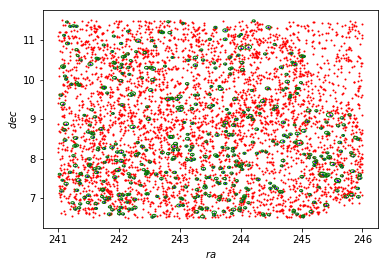

446


In [8]:
# Use KDTree to count sources within the radius defined above.

ra_lrg0 = ra[np.where(LOWZ_cut)]
ra_lrg = ra_lrg0[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]
dec_lrg0 = dec[np.where(LOWZ_cut)]
dec_lrg = dec_lrg0[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]

ra_no_lrg = ra[np.where(no_LOWZ_cut)]
# ra_no_lrg = ra_no_lrg0[np.where(lowz_tar == 0)]
dec_no_lrg = dec[np.where(no_LOWZ_cut)]
# dec_no_lrg = dec_no_lrg0[np.where(lowz_tar == 0)]

# print(len(ra_lrg))
# print(len(dec_lrg))
# print(len(ra_no_lrg))
# print(len(dec_no_lrg))

# Plots LRG sources and EDR sources
plt.scatter(ra_no_lrg, dec_no_lrg, s = 1, color='red')
plt.scatter(ra_lrg, dec_lrg, s = .5, color='blue')

# Draws circle of some radius around the LRG sources
circle = []
for i in range(len(ra_lrg)):
    circle = plt.Circle((ra_lrg[i],dec_lrg[i]), r[i], color='green', fill=False)
    plt.gcf().gca().add_artist(circle)


plt.xlabel(r'$ra$')
plt.ylabel(r'$dec$')    
plt.show()

# Creates a list of ordered pairs; zips ra and dec together so they can be fed into KDTree
# zip_list0 = list(zip(x0, y0))
zip_list0 = list(zip(ra_lrg, dec_lrg))
zip_list1 = list(zip(ra_no_lrg, dec_no_lrg))
# print(type(zip_list))
# print(zip_list)
# print(zip_list[0])

# Creates a tree of EDR sources
gal_tree = KDTree(zip_list1)

# returns a list of EDR sources that are within some radius of an LRG (nn == near neighbors)
nn = gal_tree.query_radius(zip_list0,r=r,count_only=True)
# print(nn)
print(len(nn))

In [7]:
plt.hist(nn, color='hotpink')
plt.xlabel(r'$near$ $neighbors$')
plt.ylabel(r'$counts$')
plt.show()

plt.scatter(z, nn, s = 0.5)
plt.xlabel(r'$redshift$')
plt.ylabel(r'$near$ $neighbors$')
plt.show()

# Finds flux that correspond with at least 3 observations and a flux > 0
gflux_match_LOWZ = gflux_LOWZ[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]
rflux_match_LOWZ = rflux_LOWZ[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (rflux_LOWZ > 0.) & (gflux_LOWZ > 0.))]

gmag_LOWZ = 22.5 - 2.5 * np.log10(gflux_match_LOWZ)
rmag_LOWZ = 22.5 - 2.5 * np.log10(rflux_match_LOWZ)

color_LOWZ = gmag_LOWZ - rmag_LOWZ
# print(len(color_LOWZ))
# print(gmag_LOWZ)
# print('----')
# print(rmag_LOWZ)

plt.scatter(color_LOWZ, nn, s = 0.5, color="orange")
plt.xlabel(r'$(g-r)$ $color$')
plt.ylabel(r'$near$ $neighbors$')
plt.show()

plt.scatter(rmag_LOWZ, nn, s = 0.5, color='red')
plt.xlabel(r'$r$ $magnitude$')
plt.ylabel(r'$near$ $neighbors$')
plt.show()

446
446
446


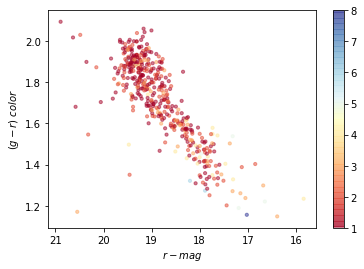

In [10]:
# This is just a color-coded CMD. Color-coded for number of near neighbors 

# Calculates gmag, rmag, and color for every LOWZ galaxy and plots a CMD

# Finds the flux in the g and r band that have at least 3 obervations in each with the flux in each > 0, calculates
# the magnitude in g and r, and calculates the (g-r) color

# Finds flux that correspond with at least 3 observations and a flux > 0
gflux_match_LOWZ = gflux_LOWZ[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (gflux_LOWZ > 0.) & (rflux_LOWZ > 0.))]
rflux_match_LOWZ = rflux_LOWZ[np.where((gobs_LOWZ >= 3) & (robs_LOWZ >= 3) & (rflux_LOWZ > 0.) & (gflux_LOWZ > 0.))]

gmag_LOWZ = 22.5 - 2.5 * np.log10(gflux_match_LOWZ)
rmag_LOWZ = 22.5 - 2.5 * np.log10(rflux_match_LOWZ)

color_LOWZ = gmag_LOWZ - rmag_LOWZ

print(len(gmag_LOWZ))
print(len(rmag_LOWZ))
print(len(color_LOWZ))

# numsats1 = numsats[np.where(numsats == 1)]
# rmag1 = rmag_LOWZ[np.where(numsats == 1)]
# color1 = color_LOWZ[np.where(numsats == 1)]

# numsats2 = numsats[np.where(numsats == 2)]
# rmag2 = rmag_LOWZ[np.where(numsats == 2)]
# color2 = color_LOWZ[np.where(numsats == 2)]

# numsats3 = numsats[np.where(numsats == 3)]
# rmag3 = rmag_LOWZ[np.where(numsats == 3)]
# color3 = color_LOWZ[np.where(numsats == 3)]

# numsats4 = numsats[np.where(numsats == 4)]
# rmag4 = rmag_LOWZ[np.where(numsats == 4)]
# color4 = color_LOWZ[np.where(numsats == 4)]

# numsats5 = numsats[np.where(numsats == 5)]
# rmag5 = rmag_LOWZ[np.where(numsats == 5)]
# color5 = color_LOWZ[np.where(numsats == 5)]

# numsats6 = numsats[np.where(numsats == 6)]
# rmag6 = rmag_LOWZ[np.where(numsats == 6)]
# color6 = color_LOWZ[np.where(numsats == 6)]

# numsats7 = numsats[np.where(numsats == 7)]
# rmag7 = rmag_LOWZ[np.where(numsats == 7)]
# color7 = color_LOWZ[np.where(numsats == 7)]

# numsats8 = numsats[np.where(numsats == 8)]
# rmag8 = rmag_LOWZ[np.where(numsats == 8)]
# color8 = color_LOWZ[np.where(numsats == 8)]

# Plots

cm = plt.cm.get_cmap('RdYlBu')

sc = plt.scatter(rmag_LOWZ, color_LOWZ, s = 10, c=nn, alpha=0.5, cmap=cm)
plt.colorbar(sc)
plt.xlabel(r'$r-mag$')
plt.ylabel(r'$(g-r)$ $color$')
plt.gca().invert_xaxis()
plt.show()


In [11]:
# Here I calculate the number of interloper galaxies for each LRG. 
# interloper galaxies Nbkg = surface density sd x solid angle omega enclosed by r defined above

# calculates solid angle subtending projected radius r
omega = []

for i in range(len(r)):
    ang = np.pi * (r[i])**2.
    omega.append(ang)

print(len(omega))
# print(omega)

Nbkg = []

for i in range(len(omega)):
    interlop = sd * omega[i]
    Nbkg.append(interlop)

print(len(Nbkg))
# print(Nbkg)

446
446


In [18]:
# Here I calculate the number of satellites for every LRG by simply subtracting the number of interloper galaxies from
# the number of near neighbors

numsats = []
numsats = nn - Nbkg

print(len(numsats))
# print(numsats)

446


1.11399999508
1.26802682645
1.45425025772
1.61840217315
4.15337274916


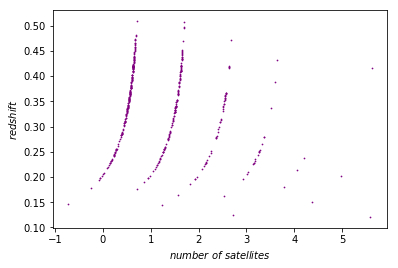

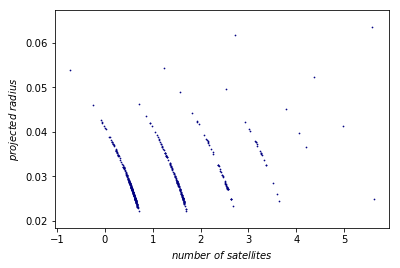

In [16]:
# compute average numsats in bins of projected radius and redshift

# compute average numsats in bins of projected radius

r = np.array(r)

n1 = numsats[np.where((r >= 0.02) & (r < 0.03))]
n1_avg = np.mean(n1)

n2 = numsats[np.where((r >= 0.03) & (r < 0.04))]
n2_avg = np.mean(n2)

n3 = numsats[np.where((r >= 0.04) & (r < 0.05))]
n3_avg = np.mean(n3)

n4 = numsats[np.where((r >= 0.05) & (r < 0.06))]
n4_avg = np.mean(n4)

n5 = numsats[np.where((r >= 0.06) & (r < 0.07))]
n5_avg = np.mean(n5)

# print(len(n1))
print(n1_avg)
print(n2_avg)
print(n3_avg)
print(n4_avg)
print(n5_avg)

# compute average numsats in bins of redshift

# nz1 = numsats[np.where((z >= 0.05) & (z < 0.1))]
# nz1_avg = np.mean(nz1)

# nz2 = numsats[np.where((z >= 0.1) & (z < 0.2))]
# nz2_avg = np.mean(nz2)

# nz3 = numsats[np.where((z >= 0.2) & (z < 0.3))]
# nz3_avg = np.mean(nz3)

# nz4 = numsats[np.where((z >= 0.3) & (z <= 0.4))]
# nz4_avg = np.mean(nz4)

# print(nz1_avg)
# print(nz2_avg)
# print(nz3_avg)
# print(nz4_avg)

plt.scatter(numsats, z, s = 0.5, color="purple")
plt.xlabel(r'$number$ $of$ $satellites$')
plt.ylabel(r'$redshift$')
plt.show()

plt.scatter(numsats, r, s = 0.5, color="navy")
plt.xlabel(r'$number$ $of$ $satellites$')
plt.ylabel(r'$projected$ $radius$')
plt.show()

# plt.scatter(n1, r[np.where((r >= 0.02) & (r < 0.03))], s = 0.5, color="navy")
# plt.xlabel(r'$number$ $of$ $satellites$')
# plt.ylabel(r'$projected$ $radius$')
# plt.show()
